# Cleaning the data

In [1]:
import pandas as pd
import numpy as np

from wordcloud import WordCloud, STOPWORDS
import gensim
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [14]:
outcomesDf=pd.read_csv("C:/Users/Alex/OneDrive/Desktop/python_proyects/outcomes.tsv", sep="\t")

In [15]:
outcomesDf.head(2)

,auction_id,product_id,item,desc,retail,price,finalprice,bidincrement,bidfee,winner,placedbids,freebids,endtime_str,flg_click_only,flg_beginnerauction,flg_fixedprice,flg_endprice
0,86827,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,13.35,13.35,15,75,Racer11,26,0,19:52 PDT 09-16-2008,0,0,0,0
1,87964,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,169.99,74.70,74.70,15,75,Cemo23,65,0,11:17 PDT 08-28-2008,0,0,0,0


In [16]:
outcomesDf.dtypes

auction_id               int64
product_id               int64
item                    object
desc                    object
retail                 float64
price                  float64
finalprice             float64
bidincrement             int64
bidfee                   int64
winner                  object
placedbids               int64
freebids                 int64
endtime_str             object
flg_click_only           int64
flg_beginnerauction      int64
flg_fixedprice           int64
flg_endprice             int64
dtype: object

La tipologías de los datas parece la apropiada a excepción de "endtime_str2", que es mejor convertirla a DataTime.

In [18]:
outcomesDf['endtime_str'] = pd.to_datetime(outcomesDf['endtime_str'])

In [19]:
outcomesDf.isnull().values.any()

False

Las columnas "retail", "price" y "finalprice" están expresadas en dolares, mientras "bidincrement" y "bidfee" se encuentran en cents, estas dos últimas las pasamos a dolares también.

In [20]:
outcomesDf['bidincrement']=outcomesDf['bidincrement']/100
outcomesDf['bidfee']=outcomesDf['bidfee']/100

In [21]:
print("Number of auctions: " + str(outcomesDf.shape[0]))
print("First auction date: " + str(min(outcomesDf['endtime_str'])))
print("Last auction date: " + str(max(outcomesDf['endtime_str'])))

Number of auctions: 121419
First auction date: 2008-08-20 14:04:00
Last auction date: 2009-12-12 15:10:00


El incremento del precio fianal depende de la subasta, va desde 1 centimo a 24 centimos.

In [23]:
np.sort(outcomesDf['bidincrement'].unique())

array([0.01, 0.02, 0.05, 0.06, 0.07, 0.12, 0.15, 0.24])

La comisión depende también de la subasta, va dese 60 céntimos a 75 céntimos.

In [24]:
np.sort(outcomesDf['bidfee'].unique())

array([0.6 , 0.75])

El número de pujas que se hicieron en cada subasta puede obtenerse a partir del precio que alcanzó la subasta y el incremento de precio de cada puja.

In [25]:
outcomesDf['bids_placed'] = outcomesDf['price']/(outcomesDf['bidincrement'])

Swoopo ofrece pujas gratuitas en determinados paquetes de ofertas, que incrementan el precio del artículo, pero el usuario no incurre en ninguna comisión de puja al realizarlas. Con la información proporcionada por este archivo de datos, no hay información que nos permita determinar cuántas pujas gratuitas se realizaron y cuántas de ellas fueron pujas no gratuitas. Los únicos datos que proporciona el conjunto de datos son el número de pujas pagadas realizadas por el ganador y el número de pujas gratuitas realizadas por el ganador. Dado que el conjunto de datos contiene esta información para 121419 subastas, por término medio, la proporción entre el número total de pujas gratuitas y pujas pagadas realizadas en una determinada subasta puede aproximarse por la proporción de las realizadas por los ganadores de la subasta.

In [26]:
print("Total number of free bids: "+str(np.sum(outcomesDf['freebids'])))
print("Total number of paid bids: "+str(np.sum(outcomesDf['placedbids'])))
ratioFreeBidsPaidBids = np.sum(outcomesDf['freebids'])/np.sum(outcomesDf['placedbids'])
print("Ratio free bids/paid bids: "+str(ratioFreeBidsPaidBids))

Total number of free bids: 414321
Total number of paid bids: 9098807
Ratio free bids/paid bids: 0.04553574990655369


Teniendo en cuenta esta aproximación, el dinero total que Swoopo obtiene por una subasta es el número de pujas no gratuitas realizadas por todos los participantes (aproximado como un 95,45% del número total de pujas realizadas) multiplicado por la comisión de puja, más el precio final de venta del artículo pagado por el ganador.

In [27]:
outcomesDf['swoopo_sale_price'] = (1-ratioFreeBidsPaidBids)*outcomesDf['bids_placed']*(outcomesDf['bidfee']) + outcomesDf['finalprice']

También  se pued obtener el beneficio.

In [28]:
outcomesDf['swoopo_profit'] = outcomesDf['swoopo_sale_price']-outcomesDf['retail']

El dinero que el ganador paga por el artículo es el precio final del artículo, más el número de pujas pagadas que haya realizado multiplicado por la comisión de puja. Por lo tanto, la diferencia entre el precio de venta al público y el dinero que el ganador paga por el artículo es el beneficio del ganador sobre el precio de venta al público del artículo:

In [29]:
outcomesDf['winner_benefit'] = outcomesDf['retail'] - (outcomesDf['finalprice'] + outcomesDf['bidfee'] * outcomesDf['placedbids'])

Se estudian las diferencias entre product_id, item y desc.

In [38]:
print(f"unicos de product_id: {len(outcomesDf['product_id'].unique())}")
print(f"unicos de item: {len(outcomesDf['item'].unique())}")
print(f"unicos de desc: {len(outcomesDf['desc'].unique())}")

unicos de product_id: 2081
unicos de item: 1803
unicos de desc: 1779


La siguiente función cuenta el número de apariciones en el conjunto de datos de cada valor único de las columnas "product_id", "item" y "desc", y crea un nuevo DataFrame indicando el número de recuento junto con los valores originales de las columnas.

In [49]:
def compareProductIdItemDescColumnValues():
    outcomesDfItemDesc =outcomesDf[['product_id','item','desc','endtime_str']]
    productIdColumnValueCounts = outcomesDf['product_id'].value_counts()
    outcomesDfItemDesc = outcomesDfItemDesc.merge(productIdColumnValueCounts.to_frame(),how='left',left_on='product_id',right_index=True)
    outcomesDfItemDesc = outcomesDfItemDesc.rename(columns={'count': 'product_id_count'})

    itemColumnValueCounts = outcomesDf['item'].value_counts()
    outcomesDfItemDesc = outcomesDfItemDesc.merge(itemColumnValueCounts.to_frame(),how='left',left_on='item',right_index=True)
    outcomesDfItemDesc = outcomesDfItemDesc.rename(columns={'count': 'item_count'})

    descColumnValueCounts = outcomesDf['desc'].value_counts()
    outcomesDfItemDesc = outcomesDfItemDesc.merge(descColumnValueCounts.to_frame(),how='left',left_on='desc',right_index=True)
    outcomesDfItemDesc = outcomesDfItemDesc.rename(columns={'count': 'desc_count'})
    
    return outcomesDfItemDesc

In [50]:
outcomesDfItemDesc = compareProductIdItemDescColumnValues()
outcomesDfItemDesc.head()

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
0,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-09-16 19:52:00,10,77,77
1,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,2008-08-28 11:17:00,21,60,60
2,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,2008-11-07 22:52:00,21,60,60
3,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-08-23 22:02:00,33,77,77
4,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-08-24 14:23:00,33,77,77


La columna "product_id" contiene valores diferentes para las filas del conjunto de datos en las que se vende el mismo artículo. Por lo tanto, el valor "product_id" no es una buena opción para identificar productos únicos. Además en algunos casos items no contiene descricpción en la columna desc. item en estos casos es una página de Html.

In [53]:

itemVsDescDf = outcomesDfItemDesc[(outcomesDfItemDesc['item_count']!=outcomesDfItemDesc['desc_count'])].drop_duplicates(subset=['item','desc'])
itemVsDescDf = itemVsDescDf.sort_values(by='desc')
itemVsDescDf.head()

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
19906,10010818,121881.html,-,2008-11-26 18:03:00,36,1,36
19294,10010818,121215.html,-,2008-11-22 20:04:00,36,1,36
19540,10010818,121470.html,-,2008-11-18 22:01:00,36,1,36
19837,10010818,121788.html,-,2008-11-24 13:05:00,36,1,36
21170,10010818,123276.html,-,2008-11-28 14:25:00,36,1,36


Dado que las subastas en las que faltan descripciones de productos no serían muy útiles para realizar análisis de datos, y que esto sólo ocurre en un pequeño número de filas, se ha decidido descartar estas filas.

In [54]:
htmlItems = ['109104.html', '109746.html', '109786.html', '109830.html',
       '110013.html', '110869.html', '111506.html', '111584.html',
       '112103.html', '112187.html', '114652.html', '114804.html',
       '114907.html', '116626.html', '117910.html', '118838.html',
       '121129.html', '121215.html', '121470.html', '121471.html',
       '121788.html', '121881.html', '123276.html', '123553.html',
       '125284.html', '125285.html', '125286.html', '125287.html',
       '125288.html', '126865.html', '126866.html', '126867.html','130108.html',
       '137897.html', '137898.html', '140035.html']
outcomesDf = outcomesDf[~outcomesDf['item'].isin(htmlItems)]

En la mayoría de los casos en que hay valores diferentes en la columna "desc" para un mismo valor de la columna "item", se debe a pequeñas diferencias gramaticales en el texto contenido en la columna "desc":

In [55]:

outcomesDfItemDesc = compareProductIdItemDescColumnValues()
itemVsDescDf = outcomesDfItemDesc[(outcomesDfItemDesc['item_count']!=outcomesDfItemDesc['desc_count'])].drop_duplicates(subset=['item','desc'])
itemVsDescDf = itemVsDescDf.sort_values(by='desc')
itemVsDescDf

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
30862,10011491,casio-exilim-ex-z200-10-1-mp-digital-cam,Casio Exilim EX-Z200 10.1 MP Digital Camera,2009-01-05 02:42:00,43,48,43
25280,10010929,casio-exilim-ex-z200-10-1-mp-digital-cam,Casio Exilim EX-Z200 10.1 MP Digital Camera - RED,2008-12-10 13:43:00,5,48,5
52065,10011838,frigidaire-atf8000fs-white-front-loading,Frigidaire ATF8000FS White Front-Loading Washer,2009-03-15 17:43:00,6,21,6
60454,10012069,frigidaire-atf8000fs-white-front-loading,Frigidaire ATF8000FS White Front-Loading Washer,2009-04-17 21:05:00,8,21,15
7691,10009192,ghd-professional-mini-styler-mk4-5-8-inc,"GHD Professional Mini Styler MK4 ( 5/8"" Inch)",2008-10-06 13:23:00,26,37,26
17351,10011006,ghd-professional-mini-styler-mk4-5-8-inc,"GHD Professional Mini Styler MK4 (5/8"" Inch)",2008-11-08 11:47:00,11,37,11
77943,10012229,garmin-n-vi-205w-4-3-inch-portable-gps-n,Garmin nüvi 205W 4.3-Inch Portable GPS Navigator,2009-06-29 04:30:00,22,37,22
74852,10012230,garmin-n-vi-205w-4-3-inch-portable-gps-n,Garmin nüvi 205W 4.3-Inch Portable GPS Navigator,2009-06-15 07:13:00,15,37,15
506,10008900,lego-city-7743-police-command-center,LEGO City 7743 - Police Command Center,2008-08-21 23:23:00,3,6,3
7652,10010875,lego-city-7743-police-command-center,LEGO City 7743: Police Command Center,2008-10-03 18:48:00,3,6,3


Se muestra un ejemplo.

In [57]:
itemVsDescDf[itemVsDescDf['item'].values == "vtech-v-smile-tv-learning-system"]

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
503,10009529,vtech-v-smile-tv-learning-system,VTech V.Smile TV Learning System,2008-08-23 05:53:00,4,22,4
13766,10011031,vtech-v-smile-tv-learning-system,Vtech - V.Smile TV Learning System,2008-11-03 04:59:00,18,22,18


Se limpian estas pequeñas diferencias.

In [58]:
outcomesDf.loc[outcomesDf['item'].values=="vtech-v-smile-tv-learning-system", 'desc'] = "Vtech - V.Smile TV Learning System"
outcomesDf.loc[outcomesDf['item'].values=="lego-city-7743-police-command-center", 'desc'] = "LEGO City 7743 - Police Command Center"
outcomesDf.loc[outcomesDf['item'].values=="samsung-t220hd-22-1080p-lcd-hdtv-monitor", 'desc'] = "Samsung T220HD 22\" 1080p LCD HDTV Monitor"
outcomesDf.loc[outcomesDf['item'].values=="ghd-professional-mini-styler-mk4-5-8-inc", 'desc'] = "GHD Professional Mini Styler MK4 (5/8\" Inch)"
outcomesDf.loc[outcomesDf['item'].values=="frigidaire-atf8000fs-white-front-loading", 'desc'] = "Frigidaire ATF8000FS White Front-Loading Washer"
outcomesDf.loc[outcomesDf['item'].values=="lg-26-5-cu-ft-side-by-side-refrigerator-", 'desc'] = "LG 26.5 cu.ft. Side-By-Side Refrigerator (White)"
outcomesDf.loc[outcomesDf['item'].values=="samsung-bd-p3600-1080p-blu-ray-disc-play", 'desc'] = "Samsung BD-P3600 1080p Blu-Ray Disc Player"
outcomesDf.loc[outcomesDf['item'].values=="garmin-n-vi-205w-4-3-inch-portable-gps-n", 'desc'] = "Garmin nüvi 205W 4.3-Inch Portable GPS Navigator"
outcomesDf.loc[outcomesDf['item'].values=="casio-exilim-ex-z200-10-1-mp-digital-cam", 'desc'] = "Casio Exilim EX-Z200 10.1 MP Digital Camera"

Aquellos que sigan teniendo diferencias en los valores únicos de item y de desc esque se tratan de diferentes versiones.

In [59]:
outcomesDfItemDesc = compareProductIdItemDescColumnValues()
itemVsDescDf = outcomesDfItemDesc[(outcomesDfItemDesc['item_count']!=outcomesDfItemDesc['desc_count'])].drop_duplicates(subset=['item','desc'])
itemVsDescDf = itemVsDescDf.sort_values(by='desc')
itemVsDescDf

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
106950,10013994,mario-sonic-at-the-olympic-winter-games-,Mario & Sonic at the Olympic Winter Games (DS),2009-10-25 03:33:00,55,110,55
106964,10013993,mario-sonic-at-the-olympic-winter-games-,Mario & Sonic at the Olympic Winter Games (Wii),2009-10-25 14:03:00,55,110,55
115882,10014797,star-wars-the-clone-wars-republic-heroes,Star Wars: The Clone Wars - Republic Heroes (PC),2009-11-15 18:38:00,24,52,24
106978,10013992,star-wars-the-clone-wars-republic-heroes,Star Wars: The Clone Wars - Republic Heroes (Wii),2009-10-24 19:36:00,28,52,28


Hay algunas subastas especiales que se expresan con valores 0-1.

In [60]:
outcomesDf[['auction_id','bidincrement','bidfee','flg_click_only','flg_beginnerauction','flg_fixedprice','flg_endprice']].head()

,auction_id,bidincrement,bidfee,flg_click_only,flg_beginnerauction,flg_fixedprice,flg_endprice
0,86827,0.15,0.75,0,0,0,0
1,87964,0.15,0.75,0,0,0,0
2,87965,0.15,0.75,0,1,0,0
3,88638,0.15,0.75,0,0,0,0
4,88639,0.15,0.75,0,0,0,0


Puede darse la situción de que algunas subastas sean especiales por más de una razón.

In [61]:
countOfTypesOfAuctions = outcomesDf.groupby(['flg_click_only','flg_beginnerauction','flg_fixedprice','flg_endprice'])['auction_id'].count()
countOfTypesOfAuctions

flg_click_only  flg_beginnerauction  flg_fixedprice  flg_endprice
0               0                    0               0               70020
                                                     1                3542
                                     1               0                1968
                1                    0               0               12891
                                                     1                 168
                                     1               0                  40
1               0                    0               0               25335
                                                     1                 814
                                     1               0                 155
                1                    0               0                6413
                                                     1                  32
                                     1               0                   5
Name: auction_id, dtype: int64

Ahora, contamos por separado el número de subastas de sólo clic, subastas de principiantes, subastas de precio fijo, subastas de precio final y "otras" subastas (que son las que no están incluidas en las otras cuatro categorías antes mencionadas).

In [62]:
isClickOnlyAuction = outcomesDf['flg_click_only'].values == 1
isBeginnerAuction = outcomesDf['flg_beginnerauction'].values == 1
isFixedPriceAuction = outcomesDf['flg_fixedprice'].values == 1
isEndPriceAuction = outcomesDf['flg_endprice'].values == 1

totalNumberOfAuctions = outcomesDf.shape[0]
totalNumberOfClickOnlyAuctions = outcomesDf[isClickOnlyAuction].shape[0]
totalNumberOfBeginnerAuctions = outcomesDf[isBeginnerAuction].shape[0]
totalNumberOfFixedPriceAuctions = outcomesDf[isFixedPriceAuction].shape[0]
totalNumberOfEndPriceAuctions = outcomesDf[isEndPriceAuction].shape[0]
totalNumberOfNormalAuctions = totalNumberOfAuctions - (totalNumberOfClickOnlyAuctions+totalNumberOfBeginnerAuctions+totalNumberOfFixedPriceAuctions+totalNumberOfEndPriceAuctions)

print('Total number of auctions = %d'%totalNumberOfAuctions)
print('Total number of click-only auctions = %d'%totalNumberOfClickOnlyAuctions)
print('Total number of beginner auctions = %d'%totalNumberOfBeginnerAuctions)
print('Total number of fixed-price auctions = %d'%totalNumberOfFixedPriceAuctions)
print('Total number of end-price auctions = %d'%totalNumberOfEndPriceAuctions)
print('Total number of \'other\' auctions = %d'%totalNumberOfNormalAuctions)


Total number of auctions = 121383
Total number of click-only auctions = 32754
Total number of beginner auctions = 19549
Total number of fixed-price auctions = 2168
Total number of end-price auctions = 4556
Total number of 'other' auctions = 62356


In [63]:
totalNumberOfNegativeProfitAuctions = outcomesDf[outcomesDf['swoopo_profit'] < 0].shape[0]
(totalNumberOfNegativeProfitAuctions/totalNumberOfAuctions)*100

47.530543815855594

En el 47,5% de las subastas Swoopo obtiene un beneficio negativo.

In [64]:
averageProfitPerItem = outcomesDf['swoopo_profit'].mean()
averageProfitPerItem

197.35105563511604

 De todas maneras el beneficio medio es positivo.

In [65]:
outcomesDf['winner_benefit'].mean()

161.60765181285683

Este es el beneficio medio que obtinene el ganador de la subasta teniendo en cuenta pe precio de mercado.

In [68]:
f = lambda x: str(x.day) + '-' + str(x.month) + '-' + str(x.year)
auctionsPerDay = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['auction_id'].count()
averageNumberOfDailyAuctions = auctionsPerDay.mean()
averageNumberOfDailyAuctions

252.88125

253 es el número de subastas medio.

In [70]:
averageProfitPerItem*averageNumberOfDailyAuctions

49906.38163782769

Se muestra por pantalla el beneficio medio diario que ontiene Swoopo.

In [71]:
averageProfitOfClickOnlyAuctions = outcomesDf[isClickOnlyAuction]['swoopo_profit'].mean()
averageProfitOfBeginnerAuctions = outcomesDf[isBeginnerAuction]['swoopo_profit'].mean()
averageProfitOfFixedPriceAuctions = outcomesDf[isFixedPriceAuction]['swoopo_profit'].mean()
averageProfitOfEndPriceAuctions = outcomesDf[isEndPriceAuction]['swoopo_profit'].mean()

isNotClickOnlyAuction = outcomesDf['flg_click_only'].values == 0
isNotBeginnerAuction = outcomesDf['flg_beginnerauction'].values == 0
isNotFixedPriceAuction = outcomesDf['flg_fixedprice'].values == 0
isNotEndPriceAuction = outcomesDf['flg_endprice'].values == 0

averageProfitOfNormalAuctions = outcomesDf[isNotClickOnlyAuction & isNotBeginnerAuction & isNotFixedPriceAuction & isNotEndPriceAuction]['swoopo_profit'].mean()

print("Average profit of click-only auctions = %0.2f"%averageProfitOfClickOnlyAuctions + "$")
print("Average profit of beginner auctions = %0.2f"%averageProfitOfBeginnerAuctions + "$")
print("Average profit of fixed-price auctions = %0.2f"%averageProfitOfFixedPriceAuctions + "$")
print("Average profit of end-price auctions = %0.2f"%averageProfitOfEndPriceAuctions + "$")
print("Average profit of \'other\' auctions = %0.2f"%averageProfitOfNormalAuctions + "$")

Average profit of click-only auctions = 53.35$
Average profit of beginner auctions = 23.70$
Average profit of fixed-price auctions = 609.20$
Average profit of end-price auctions = 224.10$
Average profit of 'other' auctions = 284.23$


Por supuesto, Swoopo incurre en diferentes costes que no se tienen en cuenta aquí, como los gastos de envío, el coste de los servidores, el coste de la electricidad, etc.

Las subastas más rentables son, en orden descendente: subastas a precio fijo, subastas "otras", subastas a precio final, subastas "sólo clic" y subastas para principiantes

<Figure size 640x480 with 0 Axes>

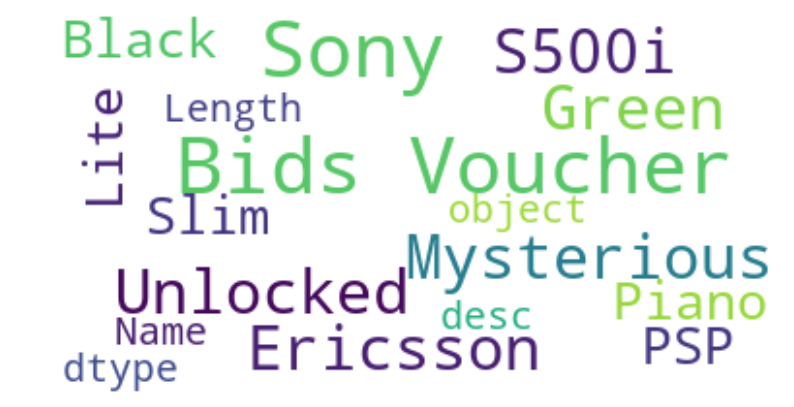

In [74]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=400,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(outcomesDf['desc']))

fig = plt.figure(1)
plt.figure(figsize=(8,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Se muestran por pantalla los productos más vendidos.

Muchos de los productos que se subastan contienen las palabras "vouncher" o "bids" en su descripción. Esto se debe a que determinados artículos vienen acompañados (o directamente lo son en algunos casos) de bids o dinero en efectivo que el ganador puede utilizar posteriormente en otras subastas de Swoopo.

In [75]:
print(outcomesDf['desc'][outcomesDf['desc'].str.contains("Bids")].unique())

['50 FreeBids Voucher' '300 FreeBids Voucher' '50 Bids Voucher'
 '300 Bids Voucher' '20 Bids Voucher'
 'Nintendo DSi Console (Black) + 50 Bids Voucher'
 'Nintendo DSi Console (Blue) + 50 Bids Voucher' '75 Bids Voucher'
 'Canon EOS Rebel T1i with 18-55mm lens + 150 Bids'
 'Sony PlayStation 3 Slim 120GB + 50 Bids'
 'Nikon D90 with 18-105mm Kit + 150 Bids'
 'Apple MacBook Pro 13.3" + 200 Bids' 'Nokia N97 + 150 Bids'
 'Sony PS3 160GB with Uncharted + 50 Bids'
 'Canon EOS Rebel T1i + 18-55mm + 150 FreeBids'
 'Nikon D90 with 18-105mm Kit + 150 FreeBids'
 'Sony PlayStation 3 Slim 250GB + 50 Bids'
 'Sony PlayStation 3 Slim 250GB + 50 FreeBids'
 'Apple MacBook Pro 13.3" + 200 FreeBids'
 'Apple iPhone 3GS 32GB Black+ 150 Bids'
 'Apple iPhone 3GS 32GB Black + 150 FreeBids'
 'Sony PS3 160GB with Uncharted + 50 FreeBids'
 'Apple iPhone 3GS 32GB Black + 200 FreeBids']


In [76]:
print(outcomesDf['desc'][outcomesDf['desc'].str.contains("Voucher")].unique())

['50 FreeBids Voucher' '300 FreeBids Voucher' '$15 Florist Voucher'
 '$30 Florist Voucher' '50 Bids Voucher' '300 Bids Voucher'
 '20 Bids Voucher' 'Nintendo DSi Console (Black) + 50 Bids Voucher'
 'Nintendo DSi Console (Blue) + 50 Bids Voucher' '75 Bids Voucher']


In [77]:
winners = outcomesDf.groupby(outcomesDf['winner'])['winner'].count()
winners.sort_values(ascending=False).head(10)

winner
HH0812         131
Oglalasioux    117
Toertchen      116
Koboldwicht    111
Schlumpf01     111
Kavvamartin    110
Thomsen321     109
Brusher        108
Aluf412        108
Trixi101       106
Name: winner, dtype: int64

Estos son los 10 usuarios que han ganado más subastas.

In [78]:
print(min(outcomesDf['endtime_str']))
print(max(outcomesDf['endtime_str']))

2008-08-20 14:04:00
2009-12-12 15:10:00


Fecha inicial y final del set de datos.

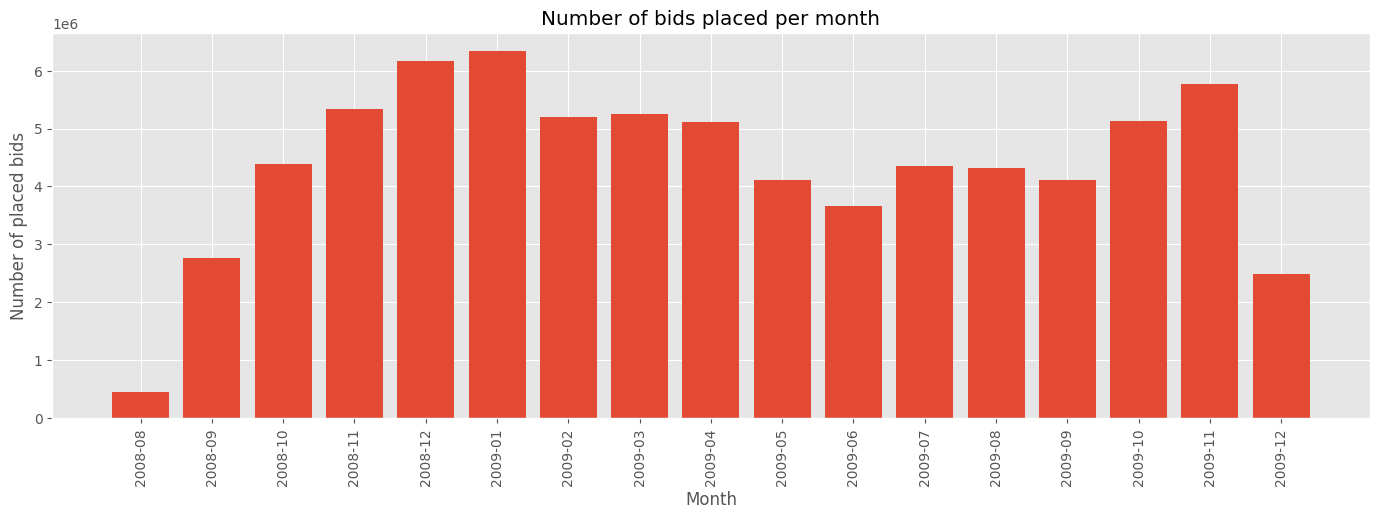

In [83]:
f = lambda x: str(x.year) + '-' + '{0:02d}'.format(x.month)

grupo = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['bids_placed'].sum()

X=grupo.values
Y=grupo.index

plt.figure(figsize=(17,5))
plt.bar(range(len(X)), X)
plt.xticks(np.arange(len(X)), Y,rotation='vertical')
plt.xlabel('Month')
plt.ylabel('Number of placed bids')
plt.title('Number of bids placed per month')
plt.show()

En la siguiente figura se representa el número de pujas realizadas por mes. La razón por la que el número de pujas realizadas en agosto de 2008 y diciembre de 2009 es bajo se debe a que el conjunto de datos no contiene datos de todos los días de estos meses. En general, puede observarse que noviembre, diciembre y enero parecen ser los meses en los que se realizan más pujas.

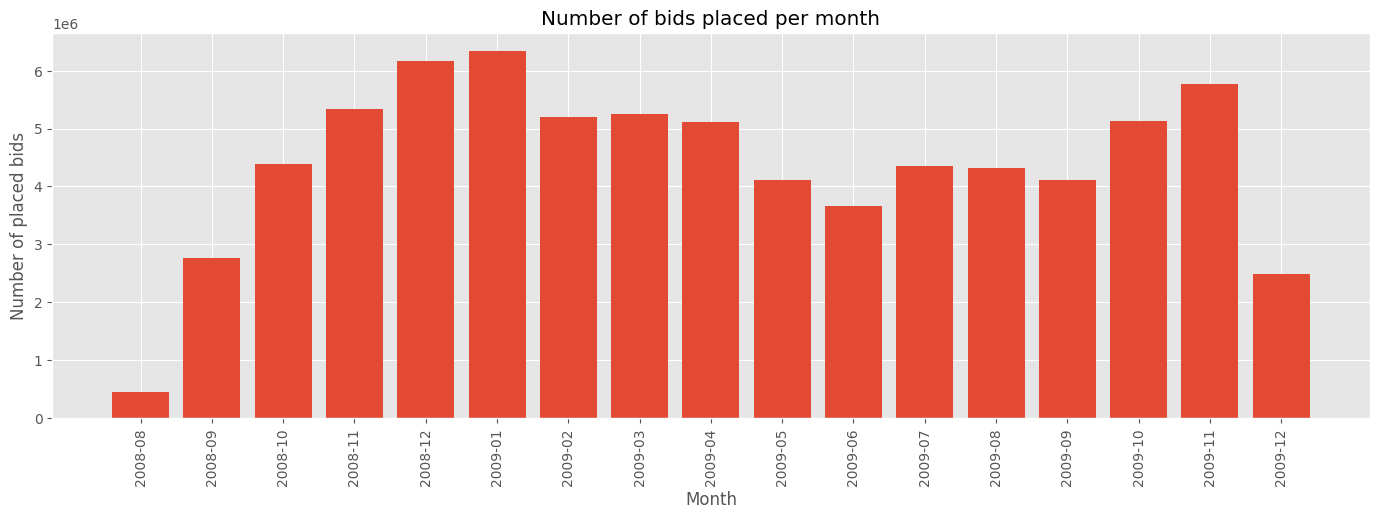

In [81]:
f = lambda x: str(x.year) + '-' + '{0:02d}'.format(x.month)

grupo = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['bids_placed'].sum()

X=grupo.values
Y=grupo.index

plt.figure(figsize=(17,5))
plt.bar(range(len(X)), X)
plt.xticks(np.arange(len(X)), Y,rotation='vertical')
plt.xlabel('Month')
plt.ylabel('Number of placed bids')
plt.title('Number of bids placed per month')
plt.show()

Considerando los meses para los que disponemos de datos completos tanto en 2008 como en 2009 (septiembre, octubre y noviembre), se puede observar que, de media, el número de pujas realizadas ha aumentado aproximadamente un 25% en 2009 en comparación con 2008. Esto indica que Swoopo ganó popularidad a lo largo de ese año.

In [86]:
september2008Index = 1
october2008Index = 2
november2008Index = 3

september20092008NumberOfBidsDiff = (X[september2008Index+12] - X[september2008Index])/X[september2008Index]
october20092008NumberOfBidsDiff = (X[october2008Index+12] - X[october2008Index])/X[october2008Index]
november20092008NumberOfBidsDiff = (X[november2008Index+12] - X[november2008Index])/X[november2008Index]
meanYearlyIncreaseNumberOfBids = np.mean([september20092008NumberOfBidsDiff,october20092008NumberOfBidsDiff,november20092008NumberOfBidsDiff])
print(meanYearlyIncreaseNumberOfBids*100)

24.738817036329106


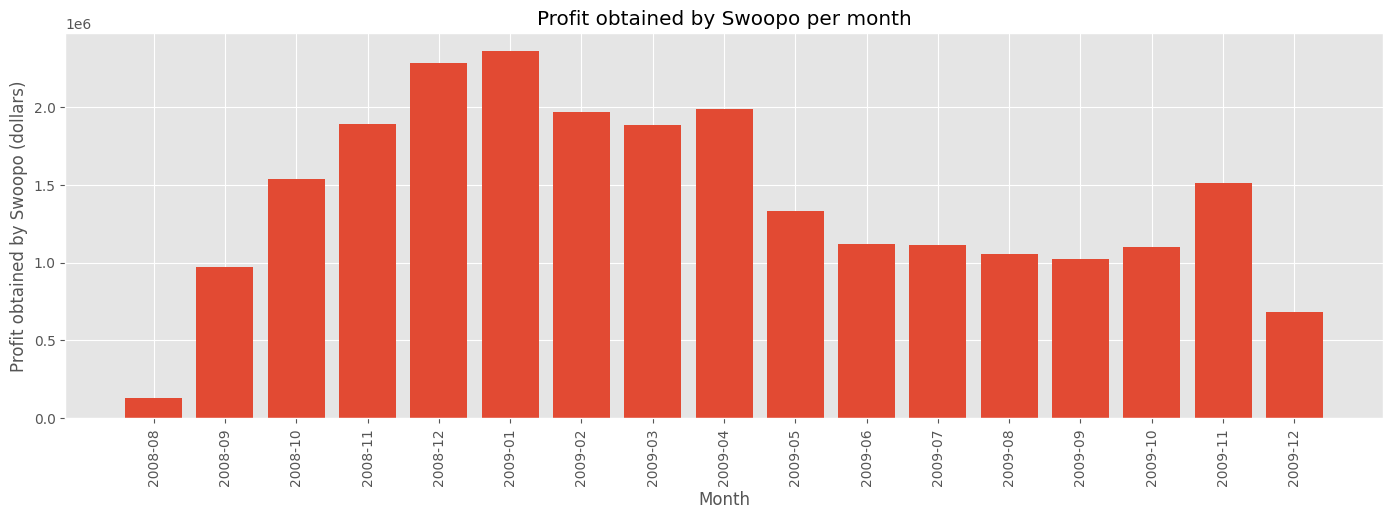

-14.472084939798954


In [88]:
f = lambda x: str(x.year) + '-' + '{0:02d}'.format(x.month)

grupo = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['swoopo_profit'].sum()

X=grupo.values
Y=grupo.index

plt.figure(figsize=(17,5))
plt.bar(range(len(X)), X)
plt.xticks(np.arange(len(X)), Y,rotation='vertical')
plt.xlabel('Month')
plt.ylabel('Profit obtained by Swoopo (dollars)')
plt.title('Profit obtained by Swoopo per month')
plt.show()

september2008Index = 1
october2008Index = 2
november2008Index = 3

september20092008SwoopoProfitDiff = (X[september2008Index+12] - X[september2008Index])/X[september2008Index]
october20092008SwoopoProfitDiff = (X[october2008Index+12] - X[october2008Index])/X[october2008Index]
november20092008SwoopoProfitDiff = (X[november2008Index+12] - X[november2008Index])/X[november2008Index]
meanYearlyIncreaseSwoopoProfit = np.mean([september20092008SwoopoProfitDiff,october20092008SwoopoProfitDiff,november20092008SwoopoProfitDiff])
print(meanYearlyIncreaseSwoopoProfit*100)

A pesar de haber aumentado el número de pujas en un 25% de 2008 a 2009, ha bajado el benefio en un 14%.

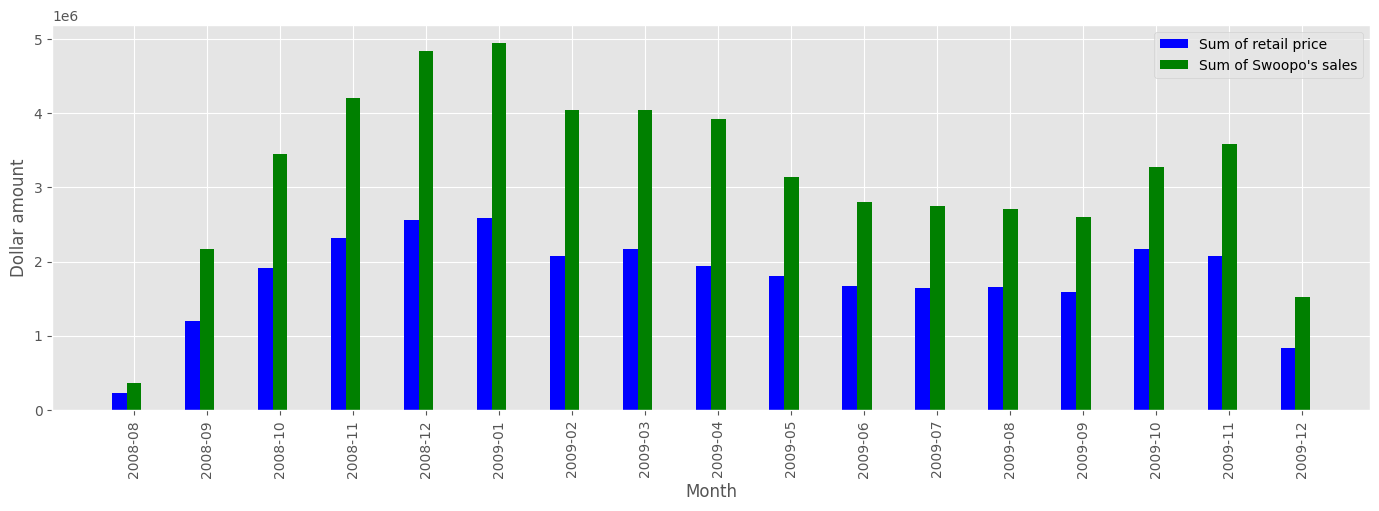

In [91]:
f = lambda x: str(x.year) + '-' + '{0:02d}'.format(x.month)

sumRetailGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['retail'].sum()
swoopoProfitGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['swoopo_profit'].sum()

X=sumRetailGroup.index
Y=sumRetailGroup.values
Y2 = swoopoProfitGroup.values
bar_width = 0.20

plt.figure(figsize=(17,5))
p1=plt.bar(np.arange(len(Y)),Y, bar_width,color='b')
p2=plt.bar(np.arange(len(Y2))+bar_width,Y2+Y,bar_width, color='g')
plt.xticks(np.arange(len(X)) + bar_width, X,rotation='vertical')
plt.legend((p1,p2),('Sum of retail price', 'Sum of Swoopo\'s sales'))
plt.xlabel('Month')
plt.ylabel('Dollar amount')
plt.show()

Esta gráfica muestra la suma por mes del los items subastados por Swoopo comparandolos con el precio de venta en el mercado.

In [92]:
profitRatio = (Y2+Y)/Y
profitRatio

array([1.5581843 , 1.80897962, 1.80403348, 1.81773936, 1.89059953,
       1.91361918, 1.94733017, 1.87027243, 2.02653824, 1.73699862,
       1.66961902, 1.68107523, 1.63396903, 1.64282709, 1.50561787,
       1.72848257, 1.81697201])

El ratio siempre es mayor que uno.

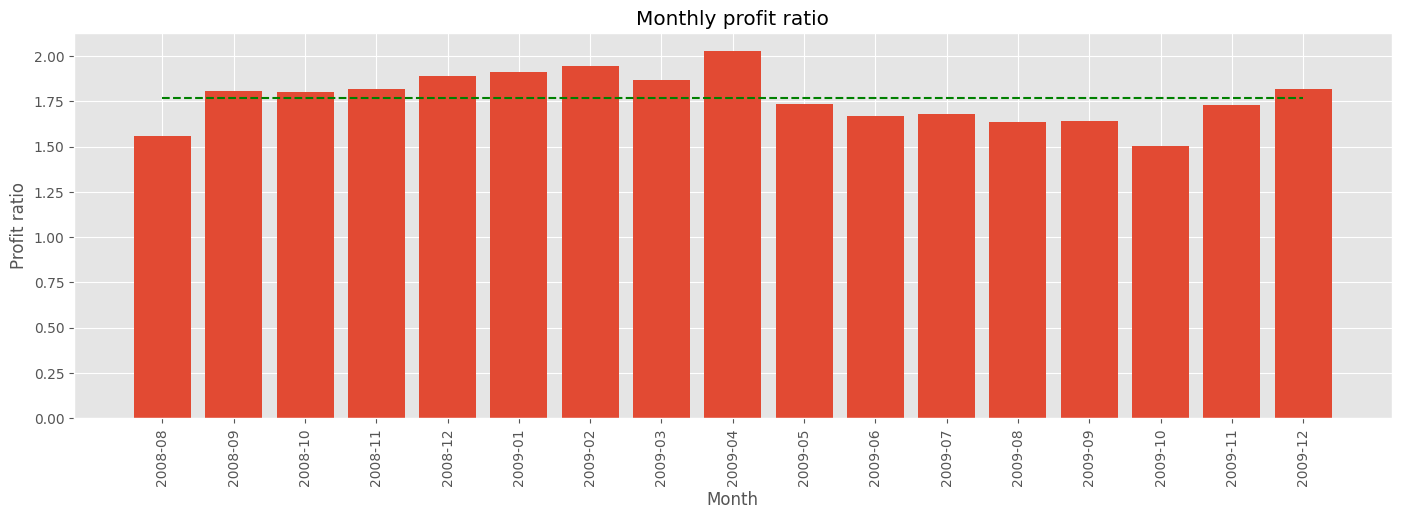

monthly average ratio: 1.7678151613959958


In [95]:
plt.figure(figsize=(17,5))
plt.bar(range(len(profitRatio)), profitRatio)
plt.xticks(np.arange(len(profitRatio)), X,rotation='vertical')
mean_line = plt.plot(np.arange(len(X)),[np.mean(profitRatio)]*len(X), label='Mean', linestyle='--',color='g')
plt.xlabel('Month')
plt.ylabel('Profit ratio')
plt.title('Monthly profit ratio')
plt.show()
print(f"monthly average ratio: {np.mean(profitRatio)}")

Este el ratio de beneficio obtenido y su media. 

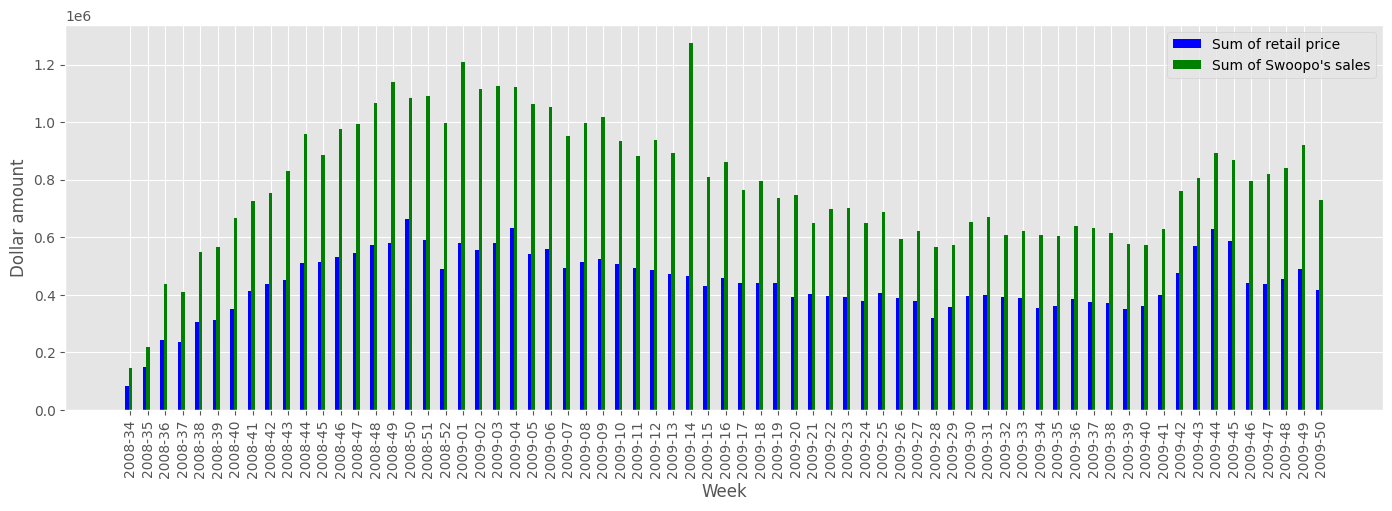

In [96]:
def timeStampToYearWeekFormat(timestamp):
    
    yearWeekFormatString = str(timestamp.year) + '-' + '{0:02d}'.format(timestamp.weekofyear)
    if yearWeekFormatString == '2008-01':
        yearWeekFormatString = '2009-01'
    return yearWeekFormatString
    
sumRetailGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(timeStampToYearWeekFormat))['retail'].sum()
swoopoProfitGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(timeStampToYearWeekFormat))['swoopo_profit'].sum()

X=sumRetailGroup.index
Y=sumRetailGroup.values
Y2 = swoopoProfitGroup.values
bar_width = 0.20

plt.figure(figsize=(17,5))
p1=plt.bar(np.arange(len(Y)),Y, bar_width,color='b')
p2=plt.bar(np.arange(len(Y2))+bar_width,Y2+Y,bar_width, color='g')
plt.xticks(np.arange(len(X)) + bar_width, X,rotation='vertical')
plt.legend((p1,p2),('Sum of retail price', 'Sum of Swoopo\'s sales'))
plt.xlabel('Week')
plt.ylabel('Dollar amount')
plt.show()

Se muestra el beneficio de Swoopo frente al precio de mercado de los items con una granularidad semanal.

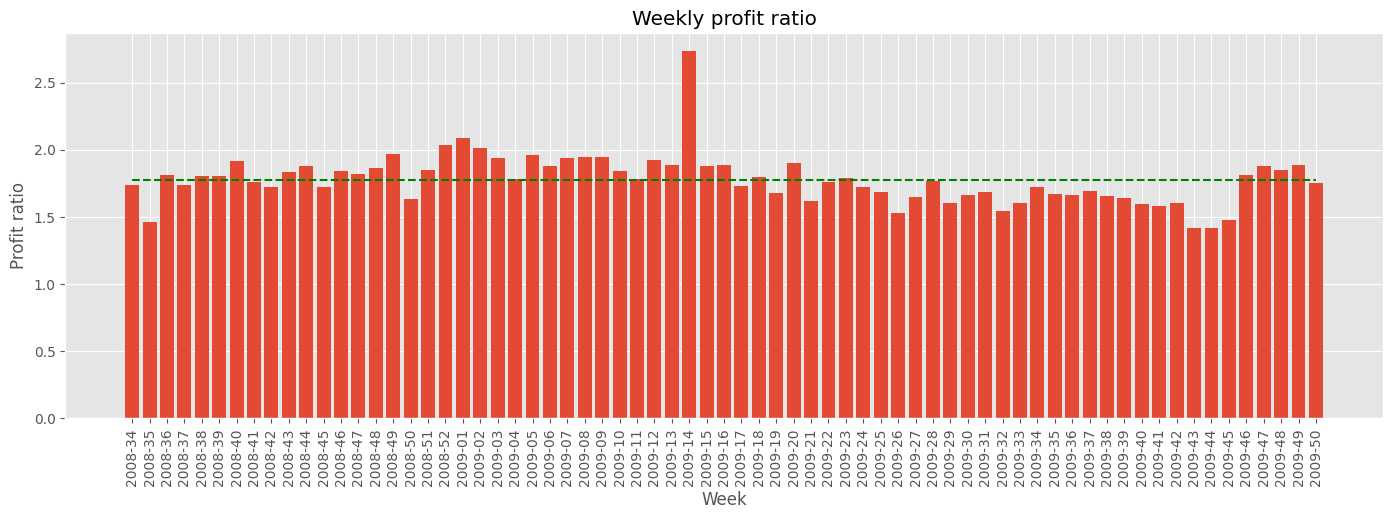

In [97]:
profitRatio = (Y2+Y)/Y
plt.figure(figsize=(17,5))
plt.bar(range(len(profitRatio)), profitRatio)
plt.xticks(np.arange(len(profitRatio)), X,rotation='vertical')
mean_line = plt.plot(np.arange(len(X)),[np.mean(profitRatio)]*len(X), label='Mean', linestyle='--',color='g')
plt.xlabel('Week')
plt.ylabel('Profit ratio')
plt.title('Weekly profit ratio')
plt.show()

Se muestra el ratio de beneficio por semana.

In [98]:
f = lambda x: str(x)[:10]

sumRetailGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['retail'].sum()
swoopoProfitGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['swoopo_profit'].sum()

X=sumRetailGroup.index
Y=sumRetailGroup.values
Y2 = swoopoProfitGroup.values

profitRatio = (Y2+Y)/Y
profitRatioZScore = (profitRatio - np.mean(profitRatio))/(np.std(profitRatio))
orderedX = X

profitRatioZScore,orderedX= zip(*sorted(zip(profitRatioZScore,orderedX),reverse=True))

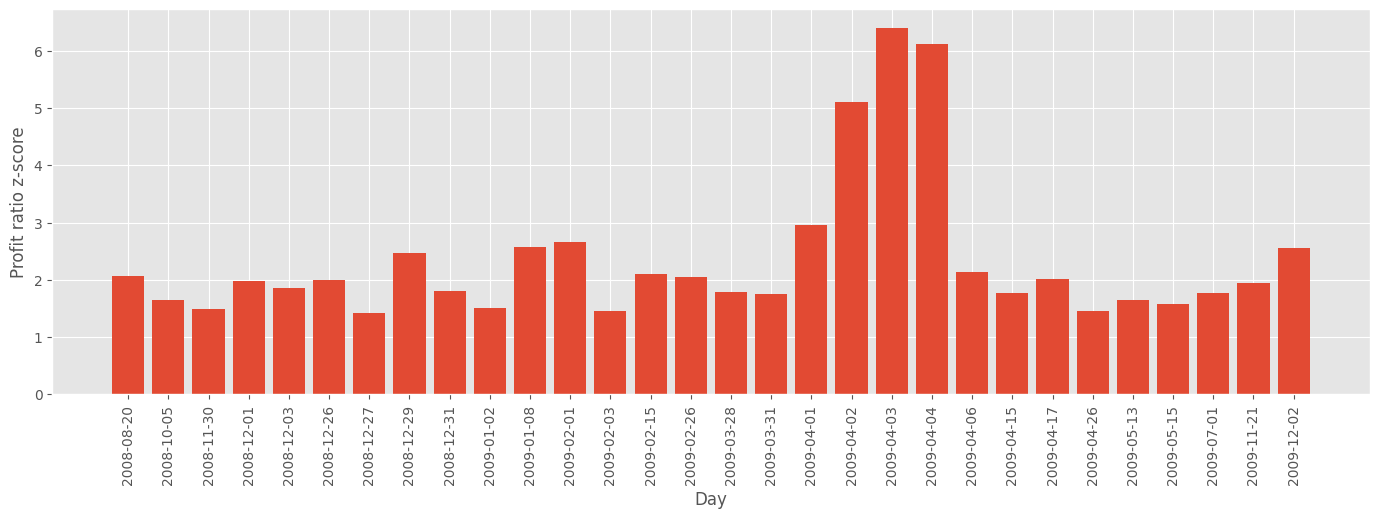

In [99]:
profitRatioZScoreTop30 = profitRatioZScore[0:30]
orderedXTop30 = orderedX[0:30]

orderedXTop30,profitRatioZScoreTop30= zip(*sorted(zip(orderedXTop30,profitRatioZScoreTop30)))

plt.figure(figsize=(17,5))
plt.bar(range(len(profitRatioZScoreTop30)), profitRatioZScoreTop30)
plt.xticks(np.arange(len(profitRatioZScoreTop30)), orderedXTop30,rotation='vertical')
plt.xlabel('Day')
plt.ylabel('Profit ratio z-score')
plt.show()

Estos son los días que se obtuvieron más beneficio.

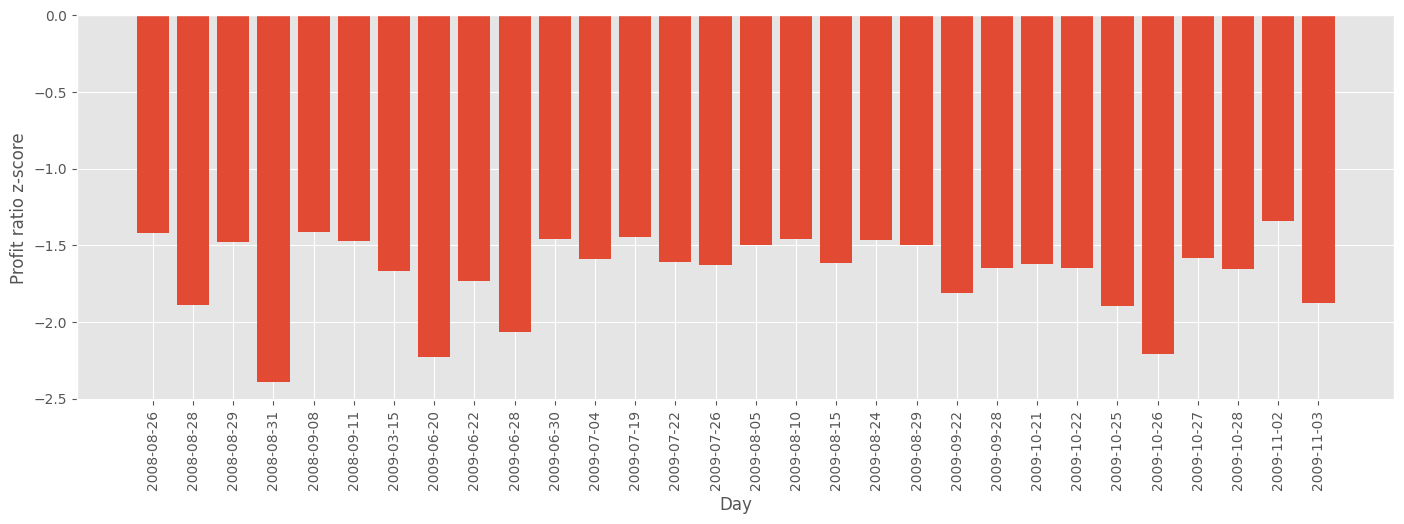

In [100]:
profitRatioZScore,orderedX= zip(*sorted(zip(profitRatioZScore,orderedX),reverse=False))
profitRatioZScore

profitRatioZScoreWorse30 = profitRatioZScore[0:30]
orderedXWorse30 = orderedX[0:30]

orderedXWorse30,profitRatioZScoreWorse30= zip(*sorted(zip(orderedXWorse30,profitRatioZScoreWorse30)))

plt.figure(figsize=(17,5))
plt.bar(range(len(profitRatioZScoreWorse30)), profitRatioZScoreWorse30)
plt.xticks(np.arange(len(profitRatioZScoreWorse30)), orderedXWorse30,rotation='vertical')
plt.xlabel('Day')
plt.ylabel('Profit ratio z-score')
plt.show()

Estos son los días que se obtuvo un beneficio más bajo.

In [103]:

federalPublicHolidaysUSA2008 = ['2008-01-01','2008-01-21','2008-02-18','2008-05-26','2008-07-04','2008-09-01','2008-10-13','2008-11-11','2008-11-27','2008-11-28','2008-12-25']
federalPublicHolidaysUSA2009 = ['2009-01-01','2009-01-19','2009-02-16','2009-05-25','2009-07-03','2009-09-07','2009-10-12','2009-11-11','2009-11-26','2009-11-27','2009-12-25']
blackFriday2008 = ['2008-11-28']
blackFriday2009 = ['2009-11-27']
valentinesDay2008Season = ['2008-02-07','2008-02-08','2008-02-09','2008-02-10','2008-02-11','2008-02-12','2008-02-13','2008-02-14']
valentinesDay2009Season = ['2009-02-07','2009-02-08','2009-02-09','2009-02-10','2009-02-11','2009-02-12','2009-02-13','2009-02-14']

christmas2008Season = []
christmas2009Season = []
for i in range (1,32):
    dayString = f"0{i}"
    christmas2008Season.append('2008-12-'+dayString)
    christmas2009Season.append('2009-12-'+dayString)

In [105]:
orderedX,profitRatioZScore= zip(*sorted(zip(orderedX,profitRatioZScore)))
holidayTypeToProfitRatioZScore = {}

for i in range(0,len(orderedX)):
    dateToAnalyzeString = str(orderedX[i])
    isFederalPublicHolidayUSA2008 =  dateToAnalyzeString in federalPublicHolidaysUSA2008
    isFederalPublicHolidayUSA2009 = dateToAnalyzeString in federalPublicHolidaysUSA2009
    isFederalPublicHolidayUSA = isFederalPublicHolidayUSA2008 or isFederalPublicHolidayUSA2009
    
    isBlackFriday2008 = dateToAnalyzeString in blackFriday2008
    isBlackFriday2009 = dateToAnalyzeString in blackFriday2009
    isBlackFriday = isBlackFriday2008 or isBlackFriday2009
    
    isValentinesDay2008Season = dateToAnalyzeString in valentinesDay2008Season
    isValentinesDay2009Season = dateToAnalyzeString in valentinesDay2009Season
    isValentinesDaySeason = isValentinesDay2008Season or isValentinesDay2009Season
    
    isChristmas2008Season = dateToAnalyzeString in christmas2008Season
    isChristmas2009Season = dateToAnalyzeString in christmas2009Season
    isChristmasSeason = isChristmas2008Season or isChristmas2009Season
    
    holidayType = []
    yearString = dateToAnalyzeString[0:4]
    
    if isFederalPublicHolidayUSA:
        holidayType.append("FederalPublicHolidayUSA")
    if isBlackFriday:
        holidayType.append("BlackFriday")
    if isValentinesDaySeason:
        holidayType.append("ValentinesDaySeason")
    if isChristmasSeason:
        holidayType.append("ChristmasSeason")
    
    if holidayType:
        for holiday in holidayType:       
            holidayTypePlusYearString = holiday + yearString
        
            if holidayTypePlusYearString in holidayTypeToProfitRatioZScore:
                holidayTypeProfitRatioZScore = holidayTypeToProfitRatioZScore[holidayTypePlusYearString]
                holidayTypeProfitRatioZScore.append((dateToAnalyzeString,profitRatioZScore[i]))
            else:
                holidayTypeToProfitRatioZScore[holidayTypePlusYearString] = [(dateToAnalyzeString,profitRatioZScore[i])]

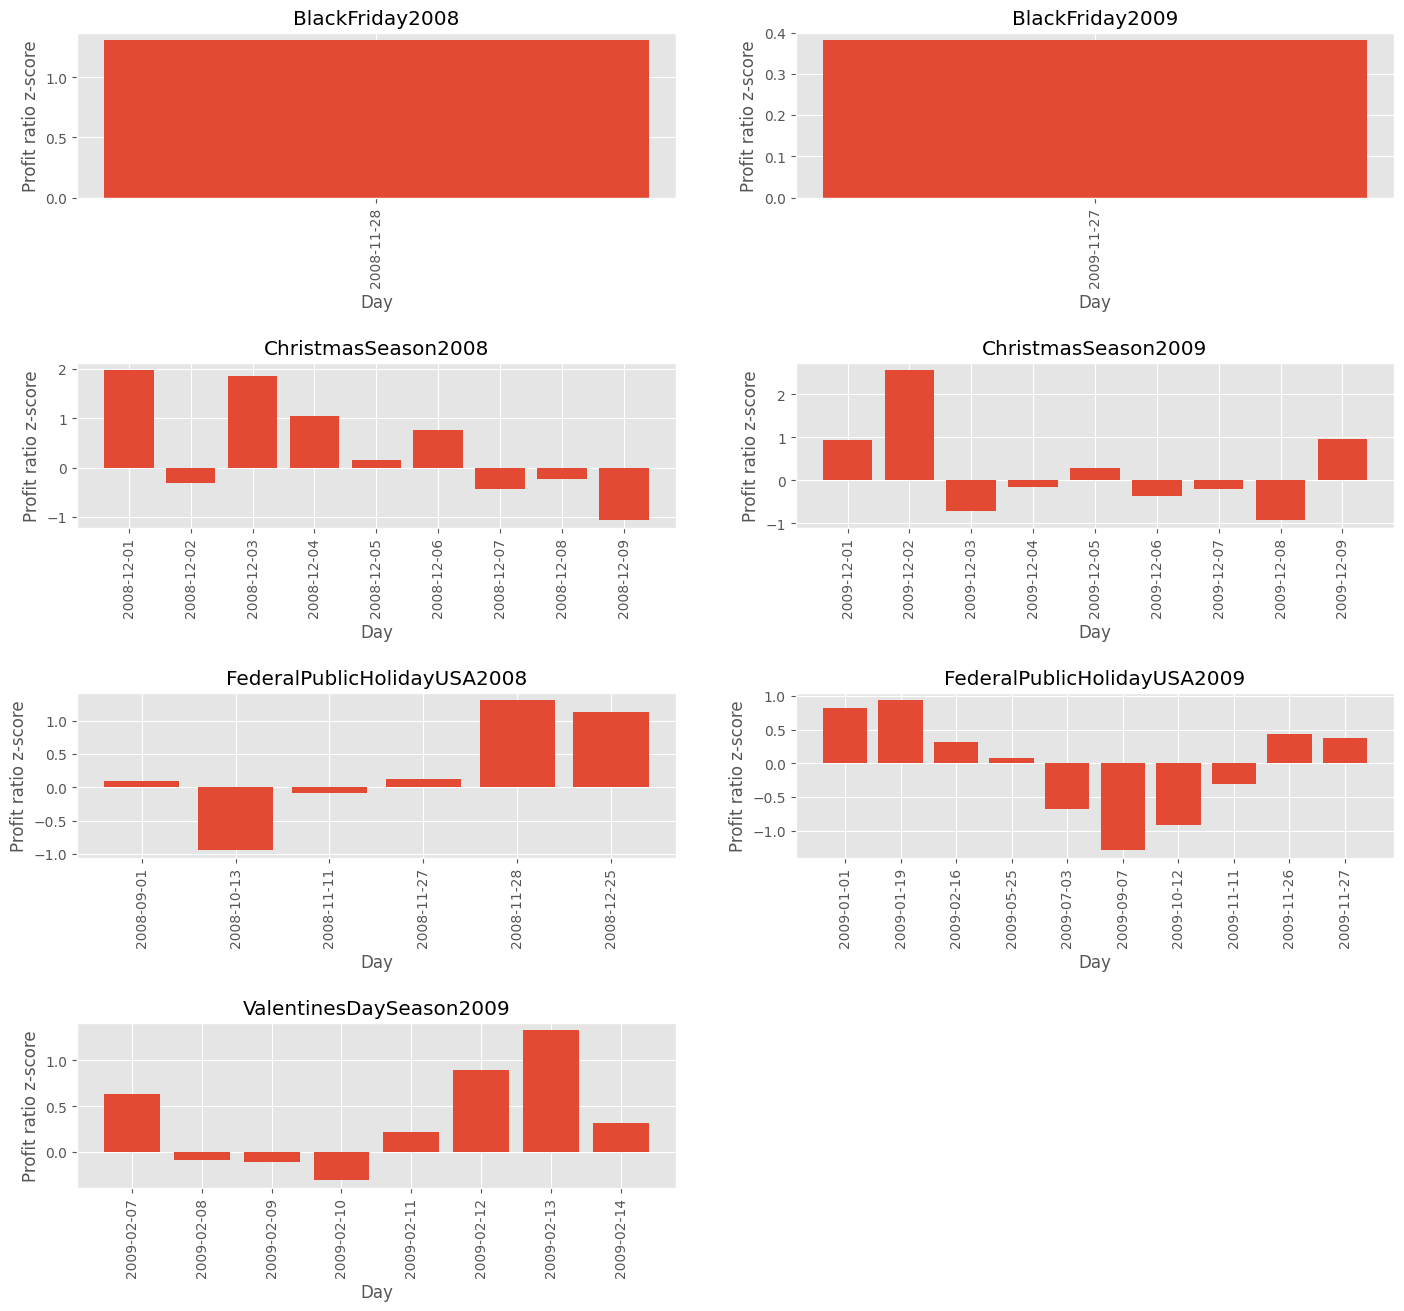

In [106]:
subplotIndex = 1

plt.figure(figsize=(17,15))  

for key in sorted(holidayTypeToProfitRatioZScore.keys()):
    value = holidayTypeToProfitRatioZScore[key]
    plt.subplot(4,2,subplotIndex)
    plt.title(key)
    
    X = [tupleElement[0] for tupleElement in value]
    Y = [tupleElement[1] for tupleElement in value]
    plt.bar(range(len(Y)), Y)
    plt.xticks(np.arange(len(Y)), X,rotation='vertical')
    plt.xlabel('Day')
    plt.ylabel('Profit ratio z-score')
    subplotIndex = subplotIndex +1
    
plt.subplots_adjust(hspace = 1)
plt.show()

Se  muestra un análisis del beneficio obtenido en los días especiiales.

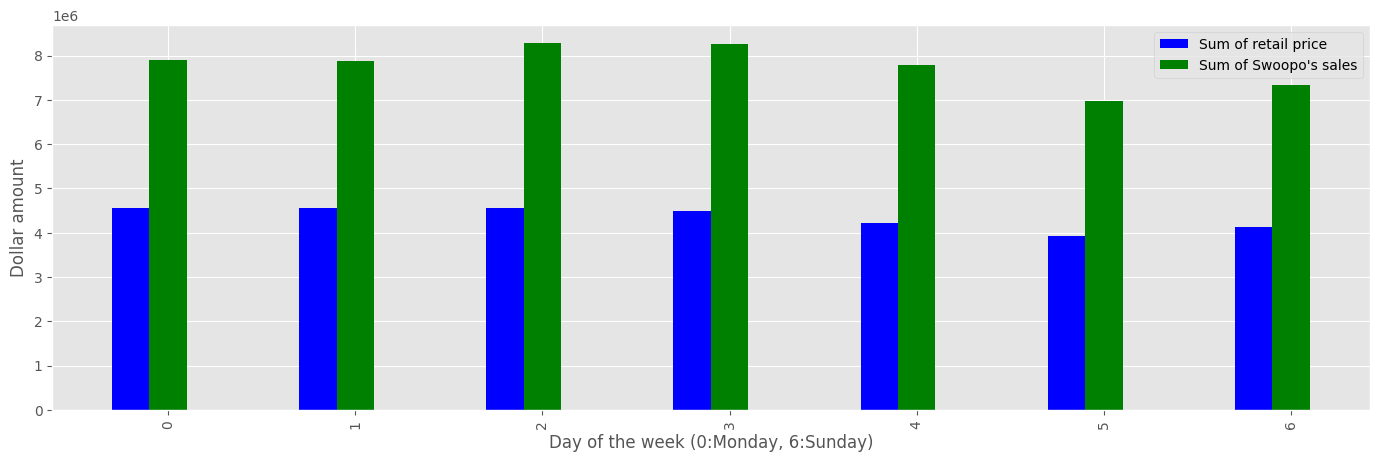

1 : 1.7241380562056736
0 : 1.7352313626318978
6 : 1.7763696888148222
5 : 1.7800256670802073
2 : 1.8181767151989512
3 : 1.8355085917496434
4 : 1.840893595827461


In [107]:
f = lambda x: str(x.dayofweek)

sumRetailGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['retail'].sum()
swoopoProfitGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['swoopo_profit'].sum()

X=sumRetailGroup.index
Y=sumRetailGroup.values
Y2 = swoopoProfitGroup.values
bar_width = 0.20

plt.figure(figsize=(17,5))
p1=plt.bar(np.arange(len(Y)),Y, bar_width,color='b')
p2=plt.bar(np.arange(len(Y2))+bar_width,Y2+Y,bar_width, color='g')
plt.xticks(np.arange(len(X)) + bar_width, X,rotation='vertical')
plt.legend((p1,p2),('Sum of retail price', 'Sum of Swoopo\'s sales'))
plt.xlabel('Day of the week (0:Monday, 6:Sunday)')
plt.ylabel('Dollar amount')
plt.show()
profitRatio = (Y2+Y)/Y
profitRatio,X= zip(*sorted(zip(profitRatio,X)))
for i in range(0,7):
    print (str(X[i])+ " : "+str(profitRatio[i]))

El profit más alto se obtiene los sábados.